In [1]:
dataset <- "ARPAFVG"
state <- "Friuli-Venezia Giulia"
match_dist <- 15000
new_dataset <- "FVG"
merging_datasets <- c("ARPAFVG", "SCIA", "ISAC")


In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
Sys.setlocale("LC_ALL", "UTF-8")
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)

source("src/database/tools.R")
source("src/database/insert.R")
source("src/database/write.R")
source("src/database/startup.R")
source("src/database/plot.R")
source("src/database/query/spatial.R")
source("src/database/query/data.R")
source("src/merging/analysis.R")
source("src/merging/display.R")
source("src/merging/combining.R")
source("src/merging/tagging.R")
source("notebooks/ds_regionali/procedure/common_steps.R")

conns <- load_dbs()
state_boundaries <- query_boundary(conns$stations, state, "state")


[1] "C/UTF-8/C/C/C/C"

Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



In [3]:
ds_meta <- query_checkpoint_meta(dataset, "qc1", conns$data) |>
    collect()
nat_meta <- query_checkpoint_meta(c("SCIA", "ISAC"), "qc1", conns$data) |>
    collect() |>
    st_md_to_sf() |>
    st_filter(state_boundaries, .predicate = st_is_within_distance, dist = units::set_units(10, "km")) |>
    st_drop_geometry() |>
    filter(!state %in% c("Veneto"), !str_starts(series_id, "AT_"))
metadata <- bind_rows(ds_meta, nat_meta) |>
    arrange(dataset, sensor_key) |>
    mutate(key = row_number()) |>
    anti_join(tibble(sensor_key = c(31L, 3984L, 2938L, 2939L, 3911L), dataset = c("ARPAFVG", "SCIA", "ISAC", "ISAC", "SCIA")), copy = TRUE, by = c("dataset", "sensor_key")) # Monfalcone, TRIESTE and TARVISIO provide terrible data + AT stations

metadata_db <- copy_to(conns$data, metadata, "metas_tmp", overwrite = TRUE)

sensor_matches <- close_matches(metadata_db, match_dist, conns$stations)

data <- query_checkpoint_data(merging_datasets, "qc1", conns$data, hive_types = list("valid" = "BOOLEAN", "variable" = "INT")) |>
    filter(valid) |>
    inner_join(metadata_db |> select(dataset, sensor_key, key), by = c("dataset", "sensor_key")) |>
    select(!c(starts_with("qc_"), valid))

var_matches <- series_matches(data, sensor_matches, metadata_db)


In [4]:
# analysis <- series_matches_analysis(var_matches, data, metadata_db, matches_offsets = c(-1L, 0L, 1L))
# analysis |> write_xlsx_analysis(file.path("notebooks", "ds_regionali", "FVG", "raw_analysis.xlsx"))
analysis <- read_parquet(file.path("notebooks", "ds_regionali", "FVG", "raw_analysis.parquet"))


In [6]:
source("notebooks/ds_regionali/FVG/procedures/match_taggers.R")
tagged_analysis <- analysis |>
    tag_same_series() |>
    default_logic(FALSE) |>
    tag_manual()

write_xlsx_analysis(tagged_analysis, file.path("notebooks", "ds_regionali", "FVG", "tagged_analysis.xlsx"), starts_with("tag_"))


In [7]:
source("src/merging/combining.R")
path_from <- prepare_data_for_merge(conns$data)
saved_to <- merge_same_series(path_from, fs::path("db", "tmp"), new_dataset, tagged_analysis, metadata, data, 10, 0L, merging_datasets, desc(dataset), desc(sensor_last))
merged_checkpoint(new_dataset, saved_to, metadata)


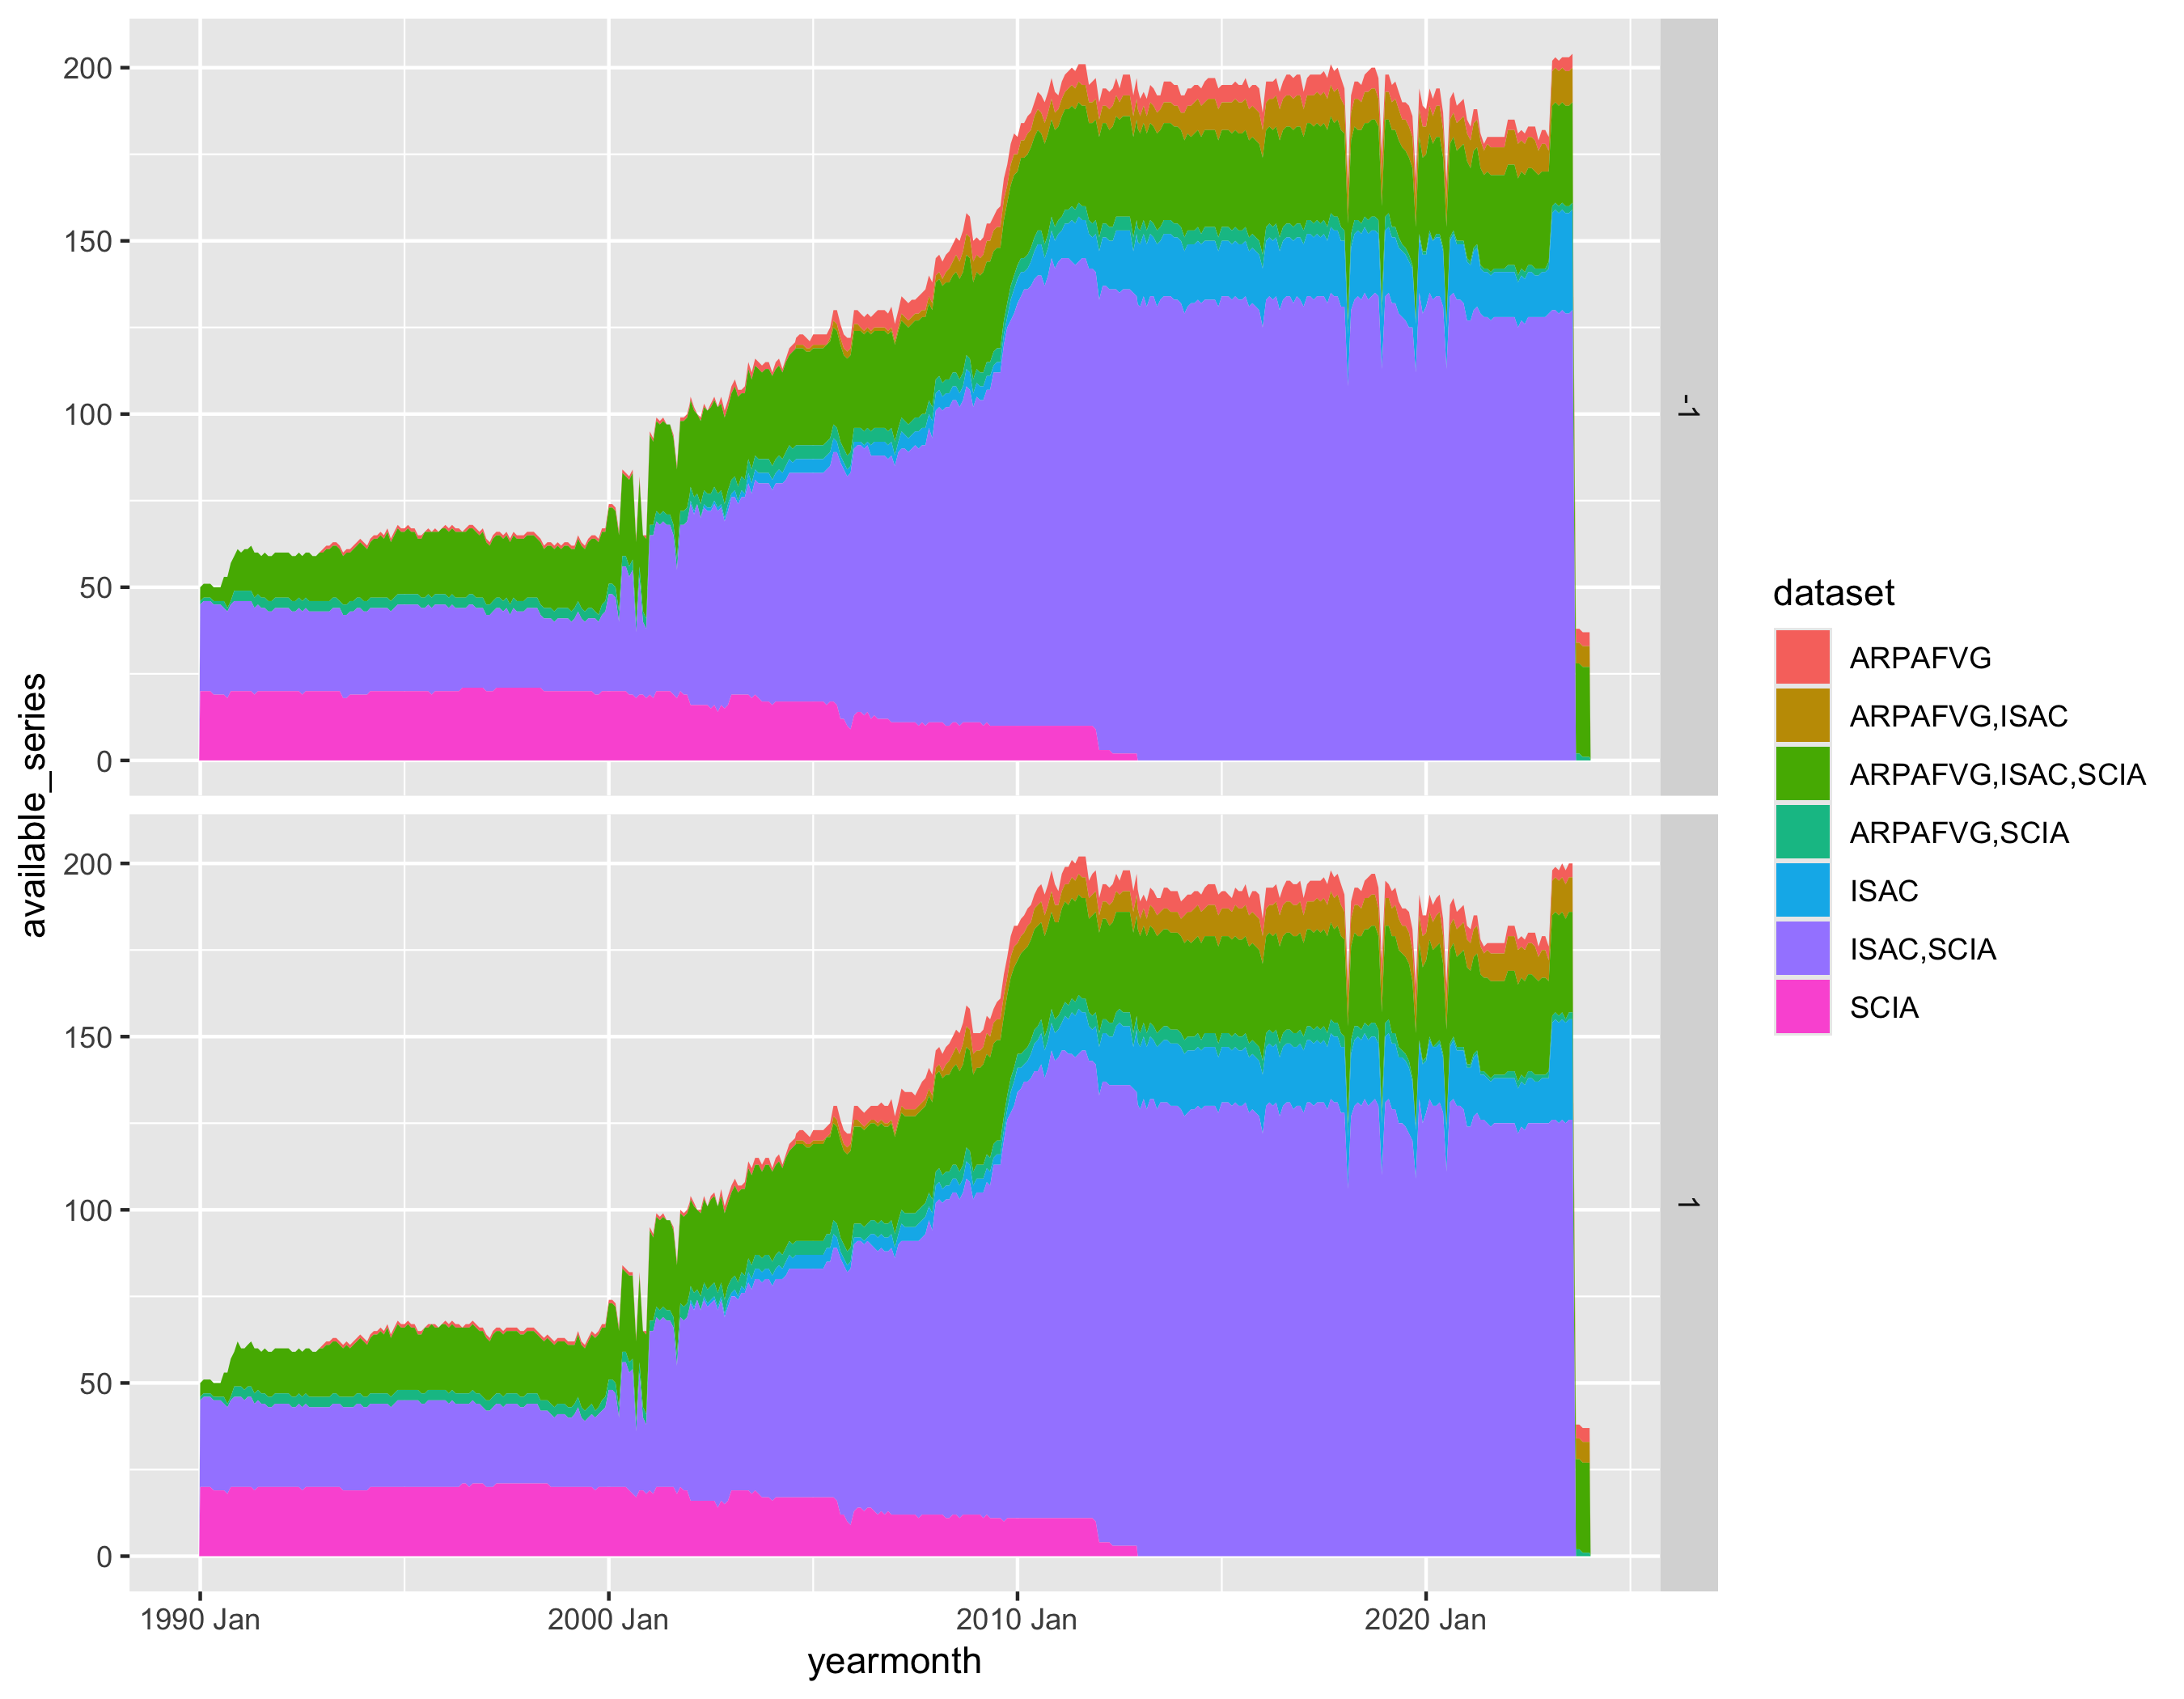

In [8]:
db <- query_checkpoint(new_dataset, "merged", conns$data, all_stations = FALSE)
mt <- db$meta |>
    select(sensor_key, from_datasets) |>
    collect() |>
    rowwise() |>
    mutate(dataset = paste0(from_datasets |> unique() |> sort(), collapse = ",")) |>
    ungroup() |>
    select(-from_datasets)
dt <- db$data |>
    select(-dataset) |>
    left_join(mt, by = "sensor_key", copy = TRUE) |>
    filter(year(date) >= 1990L)
pd <- ymonthly_availabilities(dt, stack = TRUE)
pd$plot + facet_grid(variable ~ .)


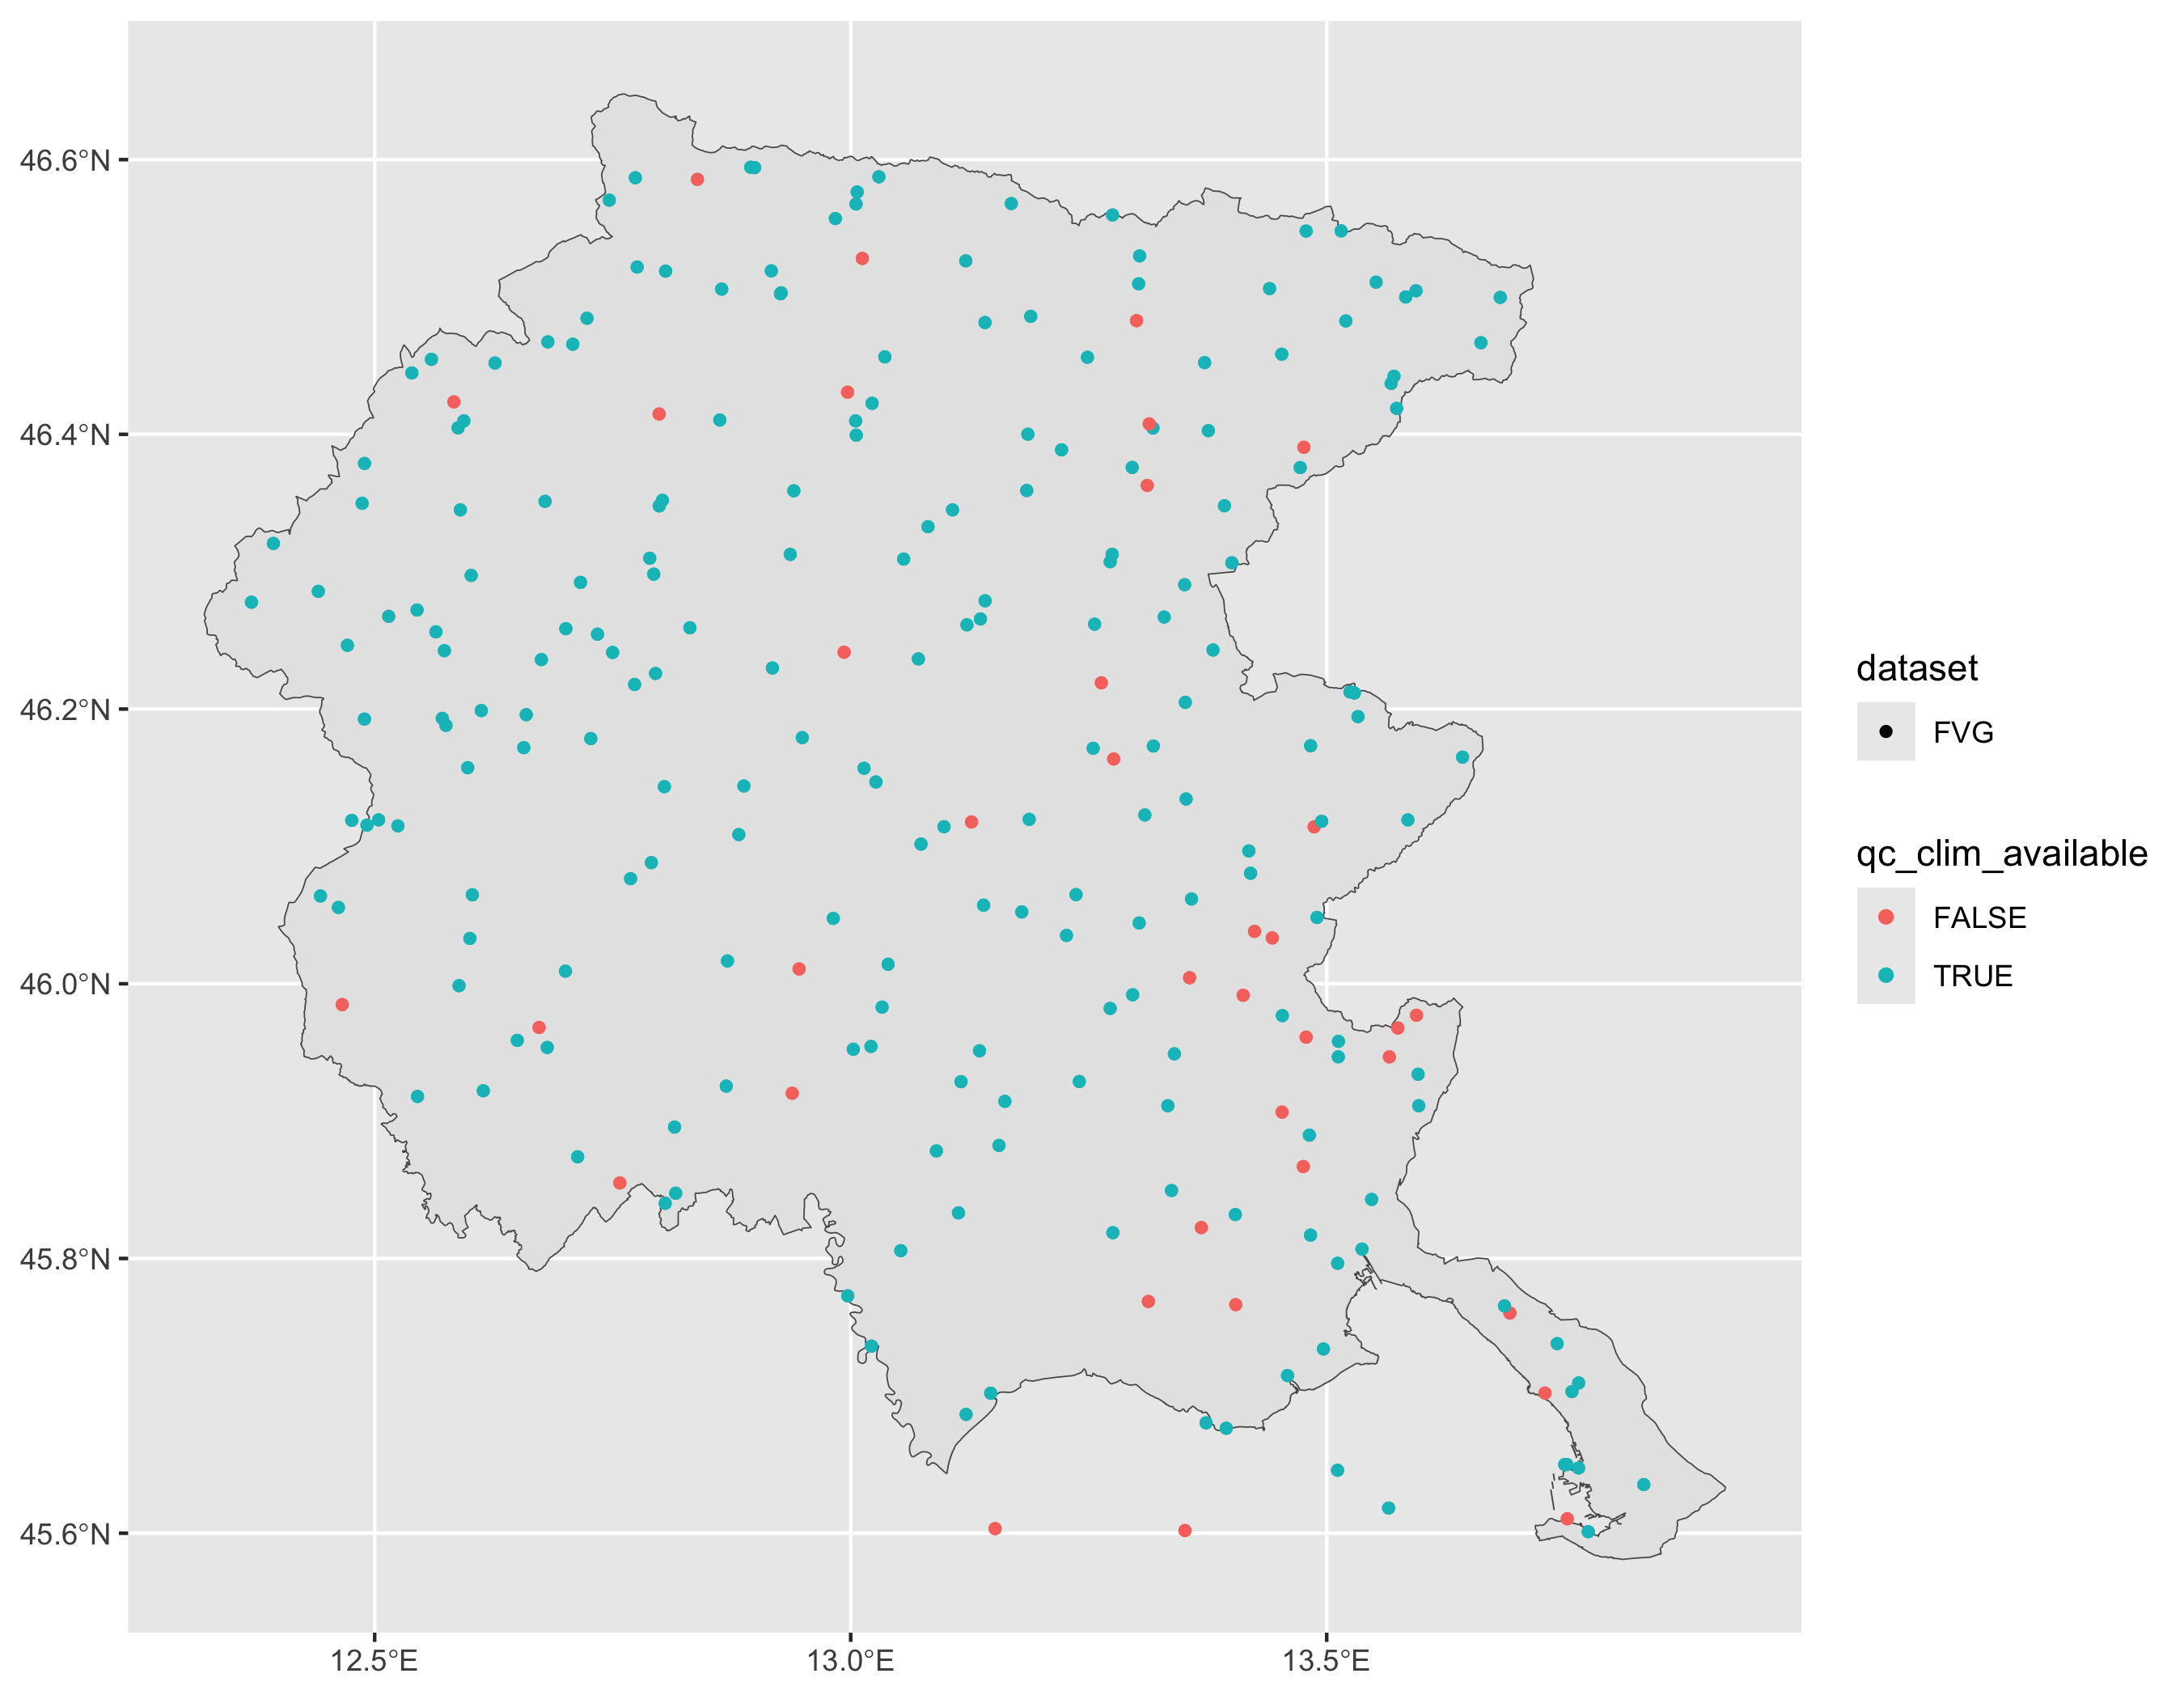

In [9]:
sp_data <- pd[[2]] |> mutate(dataset = new_dataset)
pd <- spatial_availabilities(sp_data, db$meta, state_boundaries)
pd$plot


In [10]:
merge_specs <- read_parquet(str_glue("db/extra/merge_specs/{new_dataset}.parquet")) |>
    mutate(km = k0 + 2 * k1 / pi)
merge_specs |>
    filter(abs(km) > 0.5) |>
    arrange(desc(abs(km))) |>
    left_join(metadata |> select(dataset, sensor_key, name), by = c("dataset", "sensor_key")) |>
    relocate(km, name)

km,name,set,gkey,variable,metadata_rank,data_rank,skip_correction,dataset,sensor_key,k0,k1,k2,k3,merged,offset
<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,<lgl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<int>
-1.3046255,TARVISIO,FVG,39,-1,3,3,FALSE,SCIA,3912,-1.4975227,0.30300226,0.09578833,0.0150930101,TRUE,0
-1.2698705,PIANCAVALLO,FVG,30,-1,3,3,FALSE,ISAC,2597,-1.7007088,0.67675917,-0.07610313,-0.1099584903,TRUE,0
-1.2467119,PIANCAVALLO PISTA DI FONDO,FVG,30,-1,2,2,FALSE,SCIA,2784,-1.5209105,0.43071019,-0.07449927,-0.1321087507,TRUE,0
1.2383113,Monte Lussari,FVG,24,1,3,3,FALSE,SCIA,2405,0.8500246,0.60991929,0.11587039,-0.0010598148,TRUE,0
0.8893352,Monte Lussari (fino al 08/01/2018),FVG,24,1,2,2,FALSE,ARPAFVG,32,0.6230013,0.41835631,0.04900215,-0.0596347273,TRUE,0
-0.8266881,RIFUGIO_TAMAI_ZONCOLAN,FVG,139,1,2,2,FALSE,ISAC,2973,-0.9795240,0.24007397,-0.54233851,-0.1595549842,TRUE,0
0.8133971,PALA_D_ALTEI,FVG,28,1,2,2,FALSE,ISAC,2450,0.8133971,0.00000000,0.00000000,0.0000000000,TRUE,0
0.7899038,CIVIDALE_S_M,FVG,10,1,3,3,FALSE,ISAC,991,0.7899038,0.00000000,0.00000000,0.0000000000,TRUE,0
0.7536186,Cervignano del Friuli,FVG,8,1,2,2,FALSE,SCIA,1064,0.4307584,0.50714757,0.03317416,-0.0107775234,TRUE,0
